In [1]:
# main libraries
import pandas as pd
import numpy as np
import time
# visual libraries
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D 
plt.style.use('ggplot')
# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef,classification_report,roc_curve
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv(r'Parkinsons Train Data_3.csv', header=0)
data.head()

,Jitter(local),"Jitter(local, absolute)",Jitter (rap),Jitter (ppq5),Jitter (ddp),Shimmer (local),"Shimmer (local, db)",Shimmer (apq3),Shimmer (apq5),Shimmer (apq11),...,Minimum pitch,Maximum pitch,Number of pulses,Number of periods,Mean period,Standard deviation of period,Fraction of locally unvoiced frames,Number of voice breaks,Degree of voice breaks,status
0,1.488,0.000090,0.900,0.794,2.699,8.334,0.779,4.517,4.609,6.802,...,142.229,187.576,160,159,0.006065,0.000416,0.000,0,0.000,1
1,0.728,0.000038,0.353,0.376,1.059,5.864,0.642,2.058,3.180,7.194,...,159.515,234.505,170,169,0.005181,0.000403,2.247,0,0.000,1
2,1.220,0.000074,0.732,0.670,2.196,8.719,0.875,4.347,5.166,7.548,...,146.445,211.442,1431,1427,0.006071,0.000474,10.656,1,0.178,1
3,2.502,0.000123,1.156,1.634,3.469,13.513,1.273,5.263,8.771,16.779,...,182.713,220.230,94,92,0.004910,0.000320,0.000,0,0.000,1
4,3.509,0.000167,1.715,1.539,5.145,9.112,1.040,3.102,4.927,12.823,...,182.821,225.162,117,114,0.004757,0.000380,18.182,1,13.318,1


In [3]:
data.shape

(1036, 27)

In [4]:
data.isnull().any().sum()

0

In [5]:
All = data.shape[0]
parkinsons = data[data['status'] == 1]
nonParkinsons = data[data['status'] == 0]

x = len(parkinsons)/All
y = len(nonParkinsons)/All

print('Parkinson\'s :',x*100,'%')
print('Non Parkinsons :',y*100,'%')

Parkinson's : 50.0 %
Non Parkinsons : 50.0 %


Text(0, 0.5, 'Frequency')

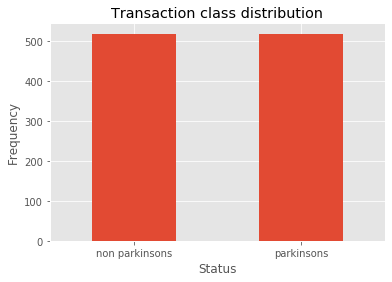

In [6]:
labels = ['non parkinsons','parkinsons']
classes = pd.value_counts(data['status'], sort = True)
classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), labels)
plt.xlabel("Status")
plt.ylabel("Frequency")

C:\Anaconda\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Anaconda\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


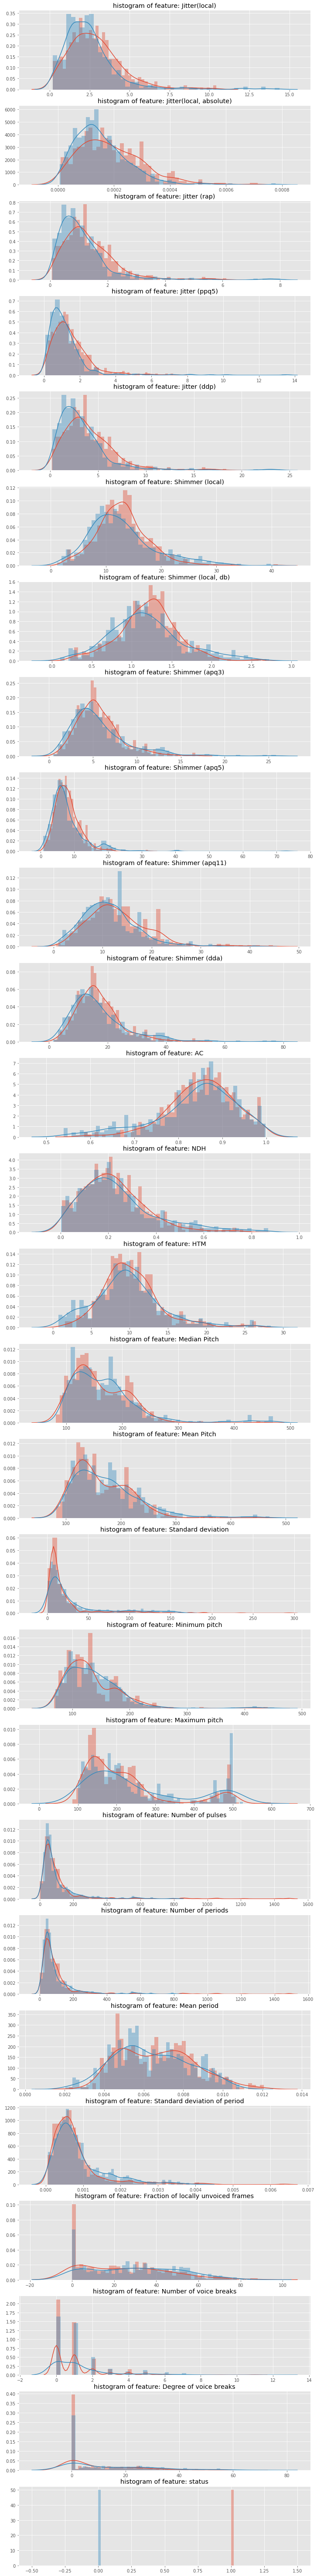

In [7]:
anomalous_features = data.iloc[:,:].columns

plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(data[anomalous_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(data[cn][data.status == 1], bins=50)
    sns.distplot(data[cn][data.status == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

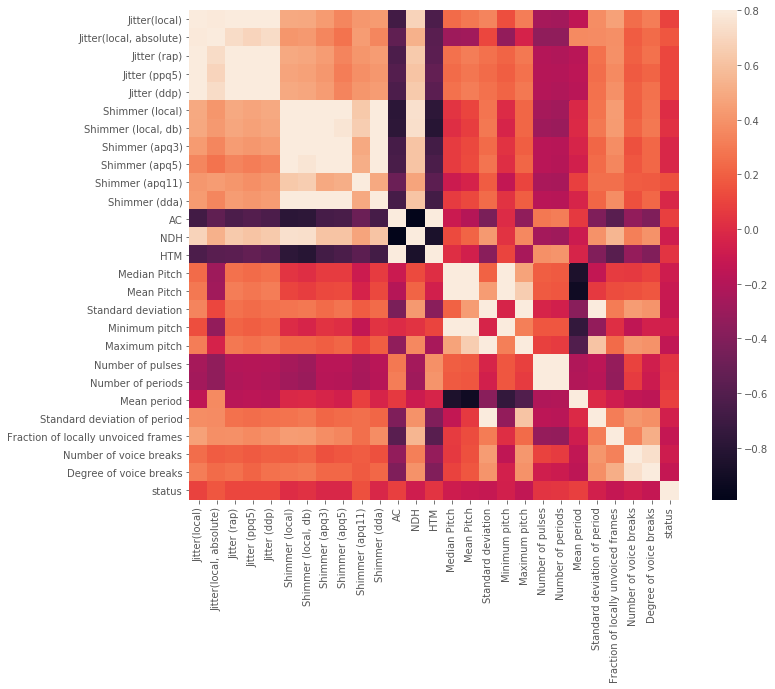

In [8]:
# heat map of correlation of features
correlation_matrix = data.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()

In [9]:
X = data.drop(['status'], axis = 1)
y = data['status']

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X.values)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, y], axis = 1)
finalDf.head()

,principal component 1,principal component 2,status
0,69.634720,-54.538413,1
1,92.141201,4.213569,1
2,1849.432928,-241.952540,1
3,-14.202435,12.588739,1
4,18.193965,18.647192,1


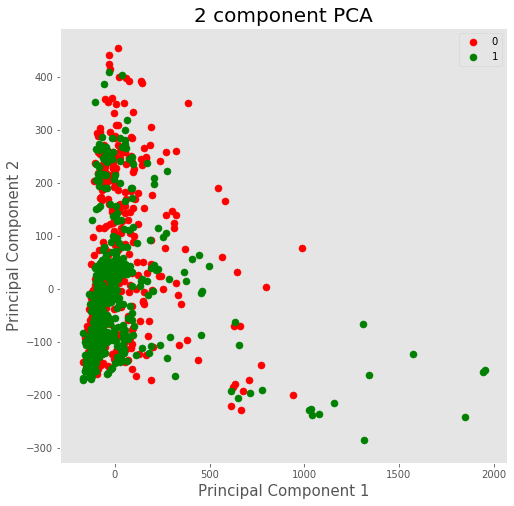

In [10]:
# 2D visualization
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['status'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [11]:
features = finalDf.drop(['status'], axis = 1)
labels = pd.DataFrame(finalDf['status'])

feature_array = features.values
label_array = labels.values

In [12]:
# splitting the faeture array and label array keeping 80% for the trainnig sets
X_train,X_test,y_train,y_test = train_test_split(feature_array,label_array,test_size=0.20)

# normalize: Scale input vectors individually to unit norm (vector length).
X_train = normalize(X_train)
X_test=normalize(X_test)

In [26]:
from sklearn.neighbors import KNeighborsClassifier
neighbours = np.arange(1,100)
train_accuracy =np.empty(len(neighbours))
test_accuracy = np.empty(len(neighbours))

for i,k in enumerate(neighbours):
    #Setup a knn classifier with k neighbors
    knn=KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",n_jobs=-1)
    
    #Fit the model
    knn.fit(X_train,y_train.ravel())
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train.ravel())
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test.ravel())

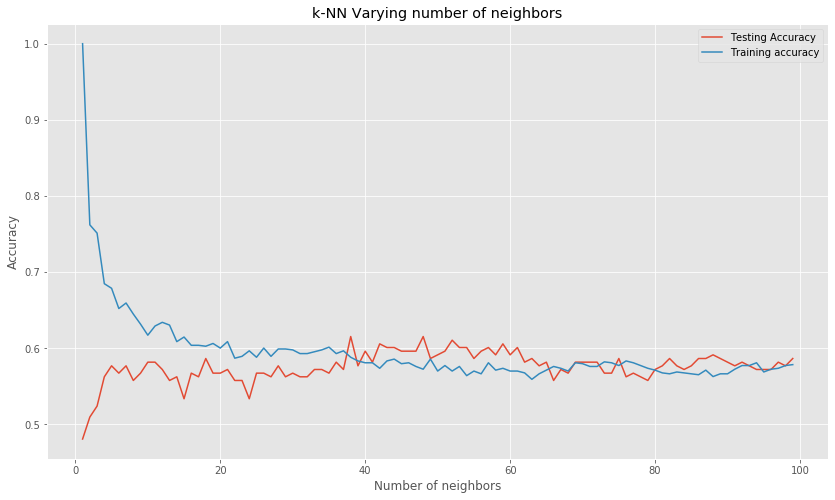

In [27]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbours, test_accuracy, label='Testing Accuracy')
plt.plot(neighbours, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [15]:
idx = np.where(test_accuracy == max(test_accuracy))
x = neighbours[idx]

In [16]:
#k_nearest_neighbours_classification
knn=KNeighborsClassifier(n_neighbors=x[0],algorithm="kd_tree",n_jobs=-1)
knn.fit(X_train,y_train.ravel())

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=18, p=2,
                     weights='uniform')

In [17]:
# predicting labels for testing set
knn_predicted_test_labels=knn.predict(X_test)

Text(0.5, 1.0, ' Number of Blobs')

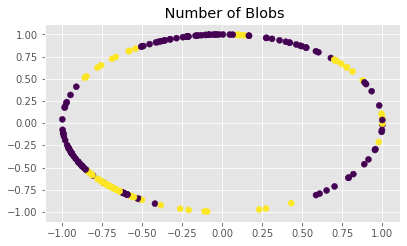

In [18]:
from pylab import rcParams
#plt.figure(figsize=(12, 12))
rcParams['figure.figsize'] = 14, 8
plt.subplot(222)
plt.scatter(X_test[:, 0], X_test[:, 1], c=knn_predicted_test_labels)
plt.title(" Number of Blobs")

In [19]:
#scoring knn
knn_accuracy_score  = accuracy_score(y_test,knn_predicted_test_labels)
knn_precison_score  = precision_score(y_test,knn_predicted_test_labels)
knn_recall_score    = recall_score(y_test,knn_predicted_test_labels)
knn_f1_score        = f1_score(y_test,knn_predicted_test_labels)
knn_MCC             =    matthews_corrcoef(y_test,knn_predicted_test_labels)

In [20]:
knn_accuracy_score

0.5865384615384616

In [21]:
knn_precison_score

0.5595238095238095

In [22]:
knn_recall_score

0.4895833333333333

In [23]:
knn_f1_score

0.5222222222222223

In [24]:
knn_MCC

0.1617739712978617

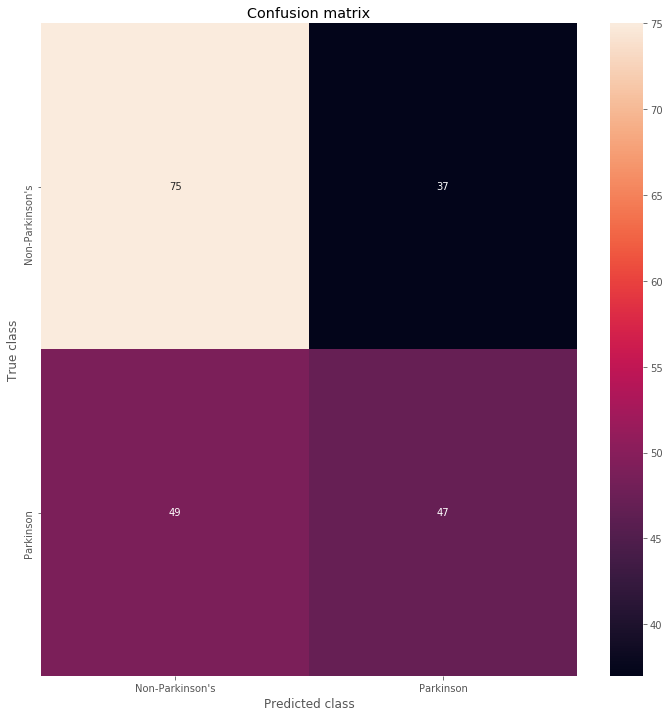

In [25]:
import seaborn as sns
LABELS = ['Non-Parkinson\'s', 'Parkinson']
conf_matrix = confusion_matrix(y_test, knn_predicted_test_labels)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()